# Analysing Heart Disease Data (Cleveland)

## Introduction
Heart disease remains one of the leading causes of death globally. Early detection using predictive modelling can dramatically enhance a patient's outcomes by allowing for timely medical intervention. I decided to examine patient data for cardiac disease at the Cleveland Clinic Foundation. The UCI Heart Disease (Cleveland) dataset is one of four available in zip file at [https://archive.ics.uci.edu/dataset/45/heart+disease]. It has 303 observations with 14 variables, with 139 patients with cardiac disease and the remaining 164 without. Using the given variables, I wish to answer the following question: **Based on the clinical variables (see methodologies), does the patient have heart disease?** The primary objective of this project is to construct a predictive model that can determine whether a patient has heart disease based on clinical variables.


## Prelimary exploratory data analysis

In order to perform our analysis, we need to load the tidyverse package, along with the tidymodels package (for the K-nearest neighbors algorithm) and the gridExtra packages.

In [19]:
library(tidyverse)
library(tidymodels)
library(gridExtra)

set.seed(54321)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




#### Reading the data set

After loading the packages, I need to read and tidy the data. The data itself is accessible online. To read it, I have to uunzip the file and open the data set I want to work with (processed.cleveland.data). The data set was provided as a .data file with comma seperated values, indicating I must use the read_csv function. However, from previewing the data, there are no column names, therefore, I will rename them following the variables that were given in [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [20]:
#downloading the URL
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_disease_temp <- tempfile()
download.file(url, heart_disease_temp)

data <- read_csv(unzip(heart_disease_temp, "processed.cleveland.data"),
                 col_names = FALSE,
                 show_col_types = FALSE) |>
        rename(age = X1, sex = X2, chest_pain = X3, resting_bp = X4,
               cholesterol = X5, fasting_blood_sugar = X6, resting_ecg = X7, 
               max_heart_rate = X8, exercise_angina = X9, st_depression = X10,
               slope = X11, major_vessels = X12, thal = X13, diagnosis = X14)

unlink(heart_disease_temp)

Now I will select which variables I want to work with such as, age, sex (which I will use only in the preliminary analysis), max heart rate, ST depression, thal, and the diagnosis. Moreover, the diagnosis is broken down into 0, 1, 2, 3, 4 variables (0 showing no heart disease and 1-4 showing heart disease), so to further clarify categories and turn this into a binary classification, I will simplify values of 1-4 as 1 to indicate heart disease.

In [21]:
chosen_columns <- data |>
    select(age, sex, max_heart_rate, st_depression, thal, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

glimpse(chosen_columns)

Rows: 303
Columns: 6
$ age            <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44,…
$ sex            <dbl> 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0…
$ max_heart_rate <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, …
$ st_depression  <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, …
$ thal           <chr> "6.0", "3.0", "7.0", "3.0", "3.0", "3.0", "3.0", "3.0",…
$ diagnosis      <fct> 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0…


#### Splitting the data

Next I will split the data into two, one training set and one testing set in order to train my classifier later on. As for now, I will work with the training set.

In [22]:
split_heart_data <- initial_split(chosen_columns)
data_training <- training(split_heart_data)
data_testing <- testing(split_heart_data)

Looking at chosen_columns table, I can see that each observation and variable have their own corresponding row and column, and that every value has its own cell, showing that the data is already tidy. This means my next steps are to create the visualizations in order to better interpret the values I have. To start, columns sex, chest_pain, and fasting_blood_sugarm need to be converted to factor variables instead of integer data types.

In [38]:
#Renaming values in sex, diagnosis, and thal columns
factor_heart_data <- data_training |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "Female" = "0", "Male" = "1")) |> #sex column
    mutate(diagnosis = fct_recode(diagnosis, "Healthy" = "0",
                                  "Amgiographic Disease" = "1")) |> #diagnosis column
    mutate(thal = as.factor(thal)) |> #thal column
    mutate(thal = fct_recode(thal, "Normal" = "3.0", 
                             "Fixed Defect" = "6.0",
                             "Reversable Defect" = "7.0")) |>
    mutate(thal = fct_relevel(thal, "Reversable Defect", after = 1))

glimpse(factor_heart_data)


Rows: 227
Columns: 6
$ age            <dbl> 58, 52, 63, 57, 71, 57, 55, 57, 52, 62, 49, 58, 59, 35,…
$ sex            <fct> Male, Male, Male, Male, Female, Male, Male, Male, Male,…
$ max_heart_rate <dbl> 131, 169, 144, 126, 125, 143, 111, 115, 158, 99, 162, 1…
$ st_depression  <dbl> 2.2, 0.0, 4.0, 1.5, 1.6, 3.0, 5.6, 1.2, 0.8, 1.8, 0.0, …
$ thal           <fct> Reversable Defect, Normal, Reversable Defect, Fixed Def…
$ diagnosis      <fct> Amgiographic Disease, Healthy, Amgiographic Disease, He…


Next, I will further summarize the data, by finding the mean for the numerical predictors (ie. age, max_heart_rate, and st_depression) and tally the count of observations for each diagnosis and comparing the males with the female counts (to identify any correlation).

Lastly, by filtering rows with "-9.0" in the "diagnosis" column (which the author denoted to any row with missing values,) I will identify the number of rows with NA values.

In [39]:
#finding missing values in the data set and the number of rows with missing values
na_values <- factor_heart_data |>
    filter(age == -9.0 | sex == "-9.0" | max_heart_rate == -9.0 |
           st_depression == -9.0 | thal == "-9.0" | diagnosis == "-9.0" |
           sex == "?" | thal == "?" | diagnosis == "?")
na_count <- na_values |>
    summarize(na_count = n())
na_values
na_count

#finding the count of each diagnosis
obsversation_count <- factor_heart_data |>
    group_by(diagnosis) |>
    summarize(count = n())
obsversation_count

#finding the sex count for both diagnoses
patient_sex <- factor_heart_data |>
    group_by(sex) |>
    summarize(count = n())
patient_sex

#finding the average values of all numberic variables
avg_values <- factor_heart_data |>
    select(age, max_heart_rate, st_depression) |>
    summarize(avg_age = mean(age), avg_max_heart_rate = mean(max_heart_rate), avg_st_depression = mean(st_depression))
avg_values

age,sex,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
53,Female,115,0,?,Healthy


na_count
<int>
1


diagnosis,count
<fct>,<int>
Healthy,125
Amgiographic Disease,102


sex,count
<fct>,<int>
Female,75
Male,152


avg_age,avg_max_heart_rate,avg_st_depression
<dbl>,<dbl>,<dbl>
54.59912,149.8018,0.9823789


The first table above indicates that 1 of the 227 observations contains a missing value. Because it is only one row, I am choosing ot filter it out rather than filling in the missing value. To do so, I will rename the missing value to "NA."

In [40]:
#renaming thal "?" to "NA"
factor_heart_data <- factor_heart_data|>
    mutate(thal = if_else(thal == "?", NA, thal))

#filtering NA from the data
data_wo_na <- filter(factor_heart_data, if_any(everything(), is.na)) 
data_wo_na

age,sex,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
53,Female,115,0,NA,Healthy


#### Visualizing the data for patterns and relationships

Now that all the data is set and ready to be analysed, to help in the analysis, I will create plots of each table.

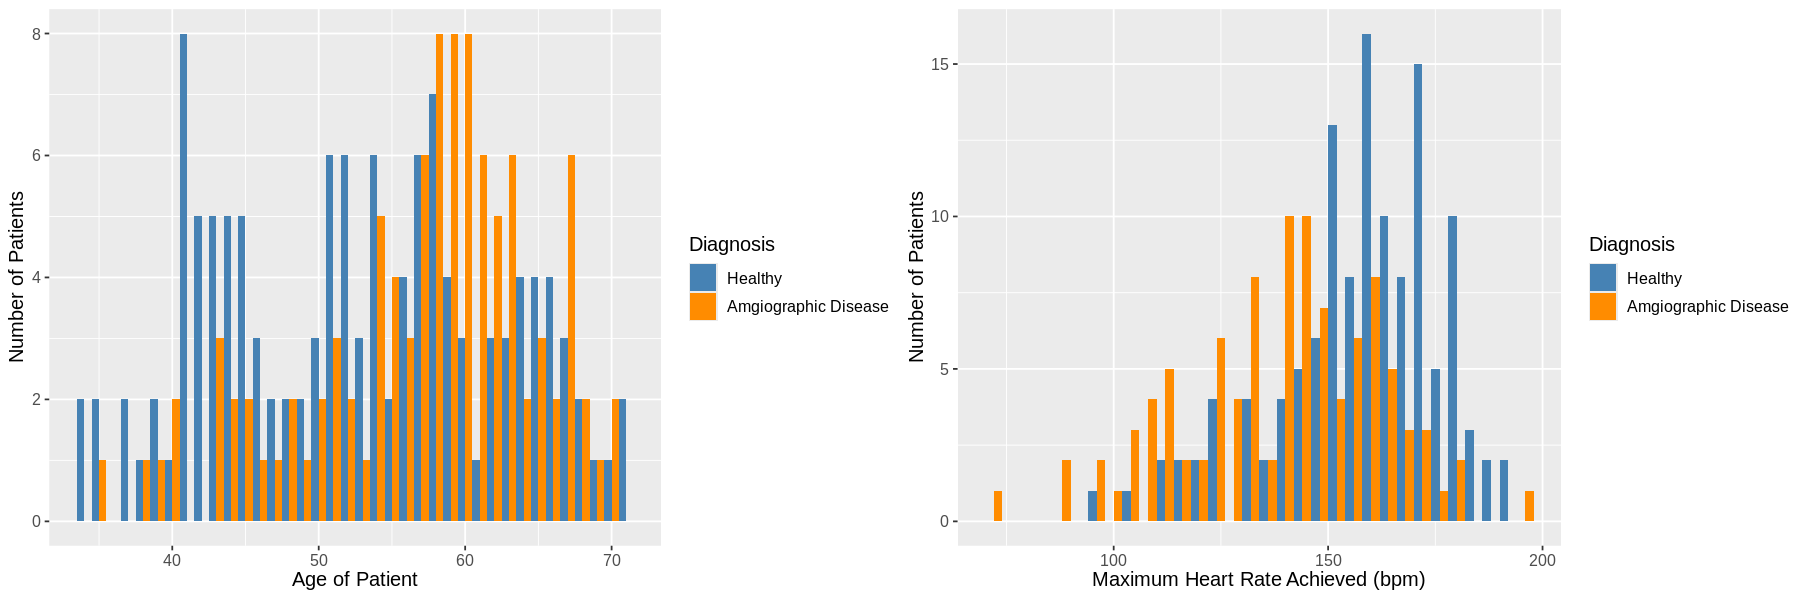

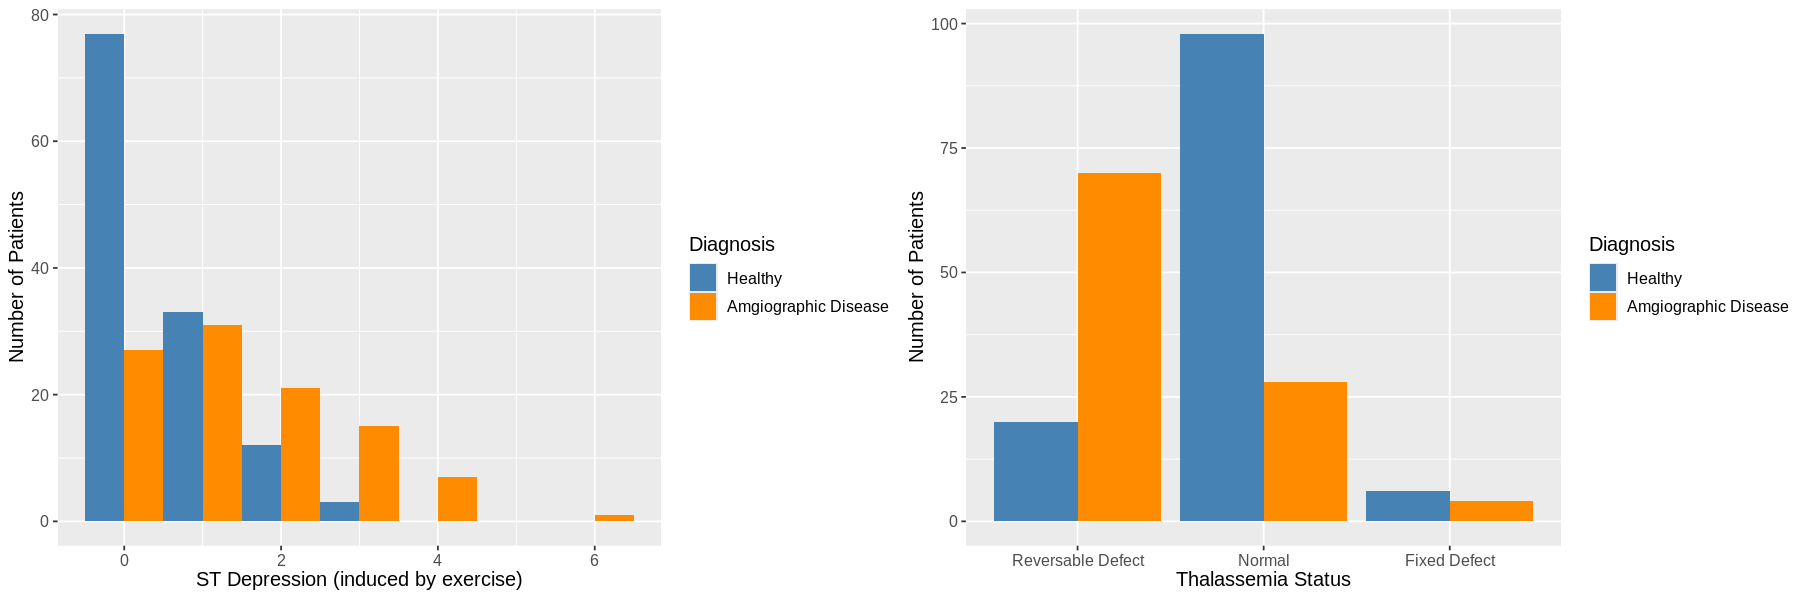

In [50]:
#plotting heart rate on a histogram
heart_rate_histo <- factor_heart_data |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 4) +
    labs(x = "Maximum Heart Rate Achieved (bpm)", y = "Number of Patients", fill = "Diagnosis") +
    theme(text = element_text(size = 12)) +
    scale_fill_manual(values = c("steelblue", "darkorange"))

#plotting age on a histogram to view its distribution and relationship with heart disease
age_histogram <- factor_heart_data |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 1) +
    labs(x = "Age of Patient", y = "Number of Patients", fill = "Diagnosis") +
    theme(text = element_text(size = 12)) +
    scale_fill_manual(values = c("steelblue", "darkorange"))

#plotting ST depression on a histogram
st_depression_histo <- factor_heart_data |>
    ggplot(aes(x = st_depression, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 1) +
    labs(x = "ST Depression (induced by exercise)", y = "Number of Patients", fill = "Diagnosis") +
    theme(text = element_text(size = 12)) +
    scale_fill_manual(values = c("steelblue", "darkorange"))

#plotting thal on a bar graph 
thal_bar <- factor_heart_data |>
    drop_na() |>
    ggplot(aes(x = thal, fill = diagnosis)) +
    geom_bar(position = "dodge") +
    labs(x = "Thalassemia Status", y = "Number of Patients", fill = "Diagnosis") +
    theme(text = element_text(size = 12)) +
    scale_fill_manual(values = c("steelblue", "darkorange"))

options(repr.plot.width = 15, repr.plot.height = 5)
grid.arrange(age_histogram, heart_rate_histo, ncol = 2)
grid.arrange(st_depression_histo, thal_bar, ncol = 2)

The plots above show a (positive( relationship between age and heart, a relationship with maximum bpm (lower max bpm shows higher increase of heart disease), and a relationship with ST depression, but no correlation with their thalassemia status.

## Methods

From the above analysis, it is evident that there is a relationship between age, maximum heart rate, and ST depression. To address the question posed in the introduction, I will use these three variables as inputs for my k-NN classification model to train it to predict the presence of heart disease. By excluding the other 11 variables, I can ensure that the model is not influenced by variables that do not correlate with heart disease prediction. I will split the dataset into training and testing sets to perform cross-validation, allowing me to determine the optimal number of neighbors (K) for the k-NN model. Additionally, I will create a line plot to visualize the relationship between K and the model's accuracy. To further validate the chosen K, I will evaluate the model using accuracy, precision, and recall with the testing set. Finally, I will create a bar plot to visualize the confusion matrix for a clearer evaluation of the classifier's performance.

## Expected Outcomes and Significance

I expect to create a trained predictive model that can classify the presence of heart disease using the three variables mentioned earlier, achieving reasonable accuracy. By identifying heart disease risk factors, this model can potentially aid in early preventative healthcare measures for patients. Additionally, this model can serve as a foundation for developing more complex and accurate predictive systems to assist in patient diagnosis. This could lead to future questions such as: What other diseases can be diagnosed using this type of classification? How might the model be improved to ensure accuracy when applied to a wider population?